# Run deep learning models on GPUs with Amazon SageMaker endpoints (SME) with ONNX backend on Triton Server


[Amazon SageMaker](https://aws.amazon.com/sagemaker/) provides a scalable and cost-effective way to deploy large number of deep learning models. 

<div class="alert alert-info"> <strong> Note </strong>
This notebook was tested with the `conda_python3` kernel on an Amazon SageMaker notebook instance of type `g4dn.xlarge`. It is a modified version of the original version of this sample notebook <a href="https://github.com/aws/amazon-sagemaker-examples/blob/main/multi-model-endpoints/SME-on-gpu/cv/resnet50_mme_with_gpu.ipynb">Here</a> by <a href="https://github.com/vikramelango">Vikram Elango</a>
</div>

## Amazon SageMaker Model endpoints with GPU Support

Amazon SageMaker endpoints with GPU works using [NVIDIA Triton Inference Server](https://github.com/triton-inference-server/server/). NVIDIA Triton Inference Server is open-source inference serving software that simplifies the inference serving process and provides high inference performance. Triton supports all major training and inference frameworks, such as TensorFlow, NVIDIA TensorRT, PyTorch, MXNet, Python, ONNX, XGBoost, scikit-learn, RandomForest, OpenVINO, custom C++, and more. It offers dynamic batching, concurrent execution, post-training quantization, optimal model configuration to achieve high performance inference.
When SageMaker receives an invocation request for a particular model, it does the following:

## How it works?

1. SageMaker routes traffic to the right instance behind the endpoint where the target model is loaded. SageMaker takes care of model management behind the endpoint, loads model to the container's memory and unloads the model based on the endpoint's traffic pattern.
2. Dynamically loads models from Amazon Simple Storage Service(S3) to the instance’s storage volume. If the invoked models are not available on instance storage volume, the model is downloaded onto instance storage volume. 
3. SageMaker loads the model to NVIDIA Triton container’s memory on GPU accelerated instance and serve the inference request. If the model is already loaded in the container memory, the subsequent requests are served faster as SageMaker does not need to download and load it again.
4. SageMaker takes care of traffic shaping to the SME endpoint, SageMaker continues to route traffic to the instance where the model is loaded. If the instance resources reach capacity due to high utilization, SageMaker unloads least used models from the container to free up resource to load more frequently used models.
5. SageMaker SME can horizontally scale using auto-scaling policy, provision additional GPU compute instances based on metrics such as GPU utilization, memory utilization etc. to serve spiky traffic to SME endpoints.

In this notebook, we will show you how to use the new features Amazon SageMaker SME with GPU with a computer vision use case. For demonstration purpose, we will use a ResNet-50 convolutional neural network pre-trained model that can classify images into 1000 categories. We will -

*  Show how to use NVIDIA Triton inference container on SageMaker SME, leverage different model frameworks such and ONNXRuntime, PyTorch and TensorRT backends. 
*  Walk you through steps to convert ResNet-50 models to optimized ONNXRuntime backend engine format along with TensorRT engine format and deploy it with SageMaker SME. 

### Installs

Installs the dependencies required to package the model and run inferences using Triton server. Update SageMaker, boto3, awscli etc

In [101]:
!pip install -qU pip awscli boto3 sagemaker
!pip install nvidia-pyindex --quiet
!pip install tritonclient[http] --quiet

### Imports and variables

In [102]:
# imports
import boto3, json, sagemaker, time
from sagemaker import get_execution_role
import numpy as np
from PIL import Image
import tritonclient.http as httpclient

# variables
s3_client = boto3.client("s3")
auto_scaling_client = boto3.client("application-autoscaling")
sample_image_name = "shiba_inu_dog.jpg"
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# sagemaker variables
role = get_execution_role()
sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
bucket = sagemaker_session.default_bucket()
prefix = "resnet50-sme-gpu-onnx"

# endpoint variables
sm_model_name = f"{prefix}-mdl-{ts}"
endpoint_config_name = f"{prefix}-epc-{ts}"
endpoint_name = f"{prefix}-ep-{ts}"
model_data_url = f"s3://{bucket}/{prefix}/"

# account mapping for SageMaker Triton Image
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}

region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
sme_triton_image_uri = (
    "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:22.12-py3".format(
        account_id=account_id_map[region], region=region, base=base
    )
)

In [103]:
model_data_url

's3://sagemaker-us-east-1-195936373558/resnet50-sme-gpu-onnx/'

In [104]:
sm_model_name

'resnet50-sme-gpu-onnx-mdl-2023-04-10-03-26-17'

In [105]:
role

'arn:aws:iam::195936373558:role/comprehend-experiment-SageMakerRole-86GFZ3R1KJEM'

### Creating Model Artifacts

This section presents overview of steps to prepare ResNet-50 pre-trained model to be deployed on SageMaker SME using Triton Inference server model configurations. 


<div class="alert alert-info"><strong> Note </strong>
We are demonstrating deployment with 2 models. However, customers can prepare and 100s of models. The models may or may not share the same framework.
</div>

#### Prepare PyTorch Model 

`generate_model_pytorch.sh` file in the `workspace` directory contains scripts to generate a PyTorch model. First, we load a pre-trained ResNet50 model using torchvision models package. We save the model as model.pt file in TorchScript optimized and serialized format. TorchScript needs an example inputs to do a model forward pass, so we pass one instance of an RGB image with 3 color channels of dimension 224X224. The script for exporting this model can be found [here](./workspace/generate_model_pytorch.sh)

In [106]:
!docker run --gpus=all --rm -it \
            -v `pwd`/workspace:/workspace nvcr.io/nvidia/pytorch:22.12-py3 \
            /bin/bash generate_model_pytorch.sh


== PyTorch ==

NVIDIA Release 22.12 (build 49968248)
PyTorch Version 1.14.0a0+410ce96

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This 

#### PyTorch Model Repository

The model repository contains model to serve, in our case it will be the `model.pt` and configuration file with input/output specifications and metadata.

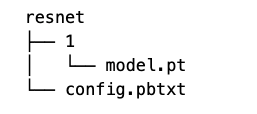

In [107]:
display.Image("images/pyt-model-repo.png")

In [108]:
!pwd

/home/ec2-user/SageMaker/cv_2023-01-29


#### PyTorch Model configuration

Model configuration file `config.pbtxt` must specify name of the model(`resnet`), the platform and backend properties (`pytorch_libtorch`), max_batch_size(128) and the input and output tensors along with the data type(TYPE_FP32) information. Additionally, you can specify `instance_group` and `dynamic_batching` properties to achieve high performance inference.

In [109]:
!mkdir -p triton-serve-pt/resnet/

In [110]:
%%writefile triton-serve-pt/resnet/config.pbtxt
name: "resnet"
platform: "pytorch_libtorch"
max_batch_size: 128
input {
  name: "INPUT__0"
  data_type: TYPE_FP32
  dims: 3
  dims: 224
  dims: 224
}
output {
  name: "OUTPUT__0"
  data_type: TYPE_FP32
  dims: 1000
}

Overwriting triton-serve-pt/resnet/config.pbtxt


#### Prepare TensorRT Model

1. We export the pre-trained ResNet50 model into an ONNX file, which runs the model once to trace its execution and then export the traced model to the specified file. It is one of the better options in terms model conversion and deployment when converting using ONNX.

2. We use `trtexec` to automatically convert ONNX model to TensorRT plan. As ONNX is framework agnostic it works with models in TF, PyTorch and more. You will export the weights of your model from the framework and load them into your TensorRT network.


In this step, we load pre-trained ResNet50 model from torch and convert to onnx representation using torch onnx exporter. Once onnx model is created, we use TensorRT trtexec command to create the model plan to be hosted with Triton. The script for exporting this model can be found [here](./workspace/generate_model_trt.sh). This is run as part of the `generate_model_trt.sh` script from the below cell.

In [111]:
!docker run --gpus=all --rm -it \
            -v `pwd`/workspace:/workspace nvcr.io/nvidia/pytorch:22.12-py3 \
            /bin/bash generate_model_trt.sh


== PyTorch ==

NVIDIA Release 22.12 (build 49968248)
PyTorch Version 1.14.0a0+410ce96

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This 

#### TensorRT Model Repository

The model repository contains model to serve, for TensorRT model it will be the model.plan(created in above steps) and configuration file with input/output specifications and metadata.

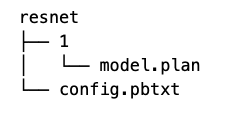

In [112]:
display.Image("images/trt-model-repo.png")

#### TensorRT Model configuration

 For the TensorRT model, we specify `tensorrt_plan` as platform, input tensor specification of the image of dimension 224X224 which has 3 color channels. Output tensor with 1000 dimensions of type TYPE_FP32 corresponding the different object categories.

#### ONNX Model configuration

 For the ONNX model, we specify `tensorrt_plan` as platform, input tensor specification of the image of dimension 224X224 which has 3 color channels. Output tensor with 1000 dimensions of type TYPE_FP32 corresponding the different object categories.

In [113]:
!mkdir -p triton-serve-onnx/resnet/

from https://github.com/triton-inference-server/server/blob/main/docs/examples/model_repository/densenet_onnx/config.pbtxt

Note that the ONNX model is already generated by the script "generate_model_trt.sh" as a substep.

In [124]:
%%writefile triton-serve-onnx/resnet/config.pbtxt
name: "resnet"
platform: "onnxruntime_onnx"
max_batch_size : 16
    
input [
  {
    name: "input"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 224, 224 ]
  }
]

output [
  {
    name: "output"
    data_type: TYPE_FP32
    dims: [ 1000 ]
  }
]

optimization { execution_accelerators {
  gpu_execution_accelerator : [ {
    name : "tensorrt"
    parameters { key: "precision_mode" value: "FP32" }
    parameters { key: "trt_engine_cache_enable" value: "true" }
    parameters { key: "trt_engine_cache_path" value: "/tmp" }      
    parameters { key: "max_workspace_size_bytes" value: "1073741824" }}
  ]
}}

dynamic_batching {
    preferred_batch_size: [1, 8, 16]
    max_queue_delay_microseconds: 250000
}

instance_group [
    {
        count: 1
        kind: KIND_GPU
    }
]

model_warmup[
    {
        name: "resnet"
        batch_size: 1
        inputs {
            key: "input"
            value: {
                data_type: TYPE_FP32
                dims: [ 3, 224, 224 ]
                random_data: true
            }
        }
    }
]





Overwriting triton-serve-onnx/resnet/config.pbtxt


#### 3. Export model artifacts to S3

SageMaker expects the model artifacts in below format, it should also satisfy Triton container requirements such as model name, version, config.pbtxt files etc. `tar` the folder containing the model file as `model.tar.gz` and upload it to s3

In [125]:
!mkdir -p triton-serve-onnx/resnet/1/
!cp -f workspace/model.onnx triton-serve-onnx/resnet/1/
!tar -C triton-serve-onnx/ -czf resnet_onnx_v1.tar.gz resnet
model_uri_onnx = sagemaker_session.upload_data(path="resnet_onnx_v1.tar.gz", key_prefix=prefix)

In [126]:
model_uri_onnx

's3://sagemaker-us-east-1-195936373558/resnet50-sme-gpu-onnx/resnet_onnx_v1.tar.gz'

Now that we have uploaded the model artifacts to S3, we can create a SageMaker endpoint.

#### Deploy Models with SME

We will now deploy ResNet-50 model with ONNX framework backends.


We will use AWS SDK for Python (Boto) APIs [create_model](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model), [create_endpoint_config](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint_config) and [create_endpoint](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint) to create a mulit-model endpoint.


#### Create a  model object

Using the SageMaker boto3 client, create the model using [create_model](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model) API. We will pass the container definition to the create model API along with ModelName and ExecutionRoleArn.


In [131]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    Containers=[{"Image": sme_triton_image_uri, 
                 "ModelDataUrl": model_uri_onnx}],
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:195936373558:model/resnet50-sme-gpu-onnx-mdl-2023-04-10-03-26-17


#### Define configuration for the endpoint


<div class="alert alert-info"> <strong> Note </strong>
Based on our findings, customers get price performance on ML optimized instances with single GPU core. Hence, this feature is only enabled for single GPU core instances. For full list of instances supported see this (https://docs.aws.amazon.com/sagemaker/latest/dg/multi-model-endpoints.html#multi-model-support to Docs page where we capture list of instances.)
</div>


In [132]:
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g4dn.4xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:195936373558:endpoint-config/resnet50-sme-gpu-onnx-epc-2023-04-10-03-26-17


#### Create Single Model Endpoint

Using the above endpoint configuration we create a new sagemaker endpoint and wait for the deployment to finish. The status will change to **InService** once the deployment is successful.

In [133]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:195936373558:endpoint/resnet50-sme-gpu-onnx-ep-2023-04-10-03-26-17


In [134]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:195936373558:endpoint/resnet50-sme-gpu-onnx-ep-2023-04-10-03-26-17
Status: InService


#### Setup Autoscaling policies for GPU endpoint

Amazon SageMaker inference endpoints supports automatic scaling (auto scaling) for your hosted models. Auto scaling dynamically adjusts the number of instances provisioned for a model in response to changes in your workload. When the workload increases, auto scaling brings more instances online. When the workload decreases, auto scaling removes unnecessary instances so that you don't pay for provisioned instances that you aren't using.

In the below scaling policy, use a custom metric GPUUtilization in TargetTrackingScalingPolicyConfiguration configuration and set a TargetValue of 60.0 for the target value of that metric. This autoscaling policy will provision additional instances upto MaxCapacity when GPU Utilization is more than 60%.

In [ ]:
# Perform auto-scaling of the endpoint based on GPU memory utilization

# This is the format in which application autoscaling references the endpoint
resource_id = "endpoint/" + endpoint_name + "/variant/" + "AllTraffic"
response = auto_scaling_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=5,
)


# GPUMemoryUtilization metric
response = auto_scaling_client.put_scaling_policy(
    PolicyName="GPUUtil-ScalingPolicy",
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="TargetTrackingScaling",  # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        # Scale out when GPU utilization hits GPUUtilization target value.
        "TargetValue": 60.0,
        "CustomizedMetricSpecification": {
            "MetricName": "GPUUtilization",
            "Namespace": "/aws/sagemaker/Endpoints",
            "Dimensions": [
                {"Name": "EndpointName", "Value": endpoint_name},
                {"Name": "VariantName", "Value": "AllTraffic"},
            ],
            "Statistic": "Average",  # Possible - 'Statistic': 'Average'|'Minimum'|'Maximum'|'SampleCount'|'Sum'
            "Unit": "Percent",
        },
        "ScaleInCooldown": 600,
        "ScaleOutCooldown": 200,
    },
)

#### Prepare Input Payload for PyTorch and TensorRT model

The following method transforms a sample image we will be using for inference into the payload that can be sent for inference to the Triton server.

The `tritonclient` package provides utility methods to generate the payload without having to know the details of the specification. We'll use the following methods to convert our inference request into a binary format which provides lower latencies for inference.

In [135]:
s3_client.download_file(
    "sagemaker-sample-files", "datasets/image/pets/shiba_inu_dog.jpg", "shiba_inu_dog.jpg"
)


def get_sample_image():
    image_path = "./shiba_inu_dog.jpg"
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img = (np.array(img).astype(np.float32) / 255) - np.array(
        [0.485, 0.456, 0.406], dtype=np.float32
    ).reshape(1, 1, 3)
    img = img / np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 1, 3)
    img = np.transpose(img, (2, 0, 1))
    return img.tolist()


def _get_sample_image_binary(input_name, output_name):
    inputs = []
    outputs = []
    inputs.append(httpclient.InferInput(input_name, [1, 3, 224, 224], "FP32"))
    input_data = np.array(get_sample_image(), dtype=np.float32)
    input_data = np.expand_dims(input_data, axis=0)
    inputs[0].set_data_from_numpy(input_data, binary_data=True)
    outputs.append(httpclient.InferRequestedOutput(output_name, binary_data=True))
    request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
        inputs, outputs=outputs
    )
    return request_body, header_length


def get_sample_image_binary_pt():
    return _get_sample_image_binary("INPUT__0", "OUTPUT__0")


def get_sample_image_binary_trt():
    return _get_sample_image_binary("input", "output")

#### Invoke target model on Sagemaker Endpoint

Once the endpoint is successfully created, we can send inference request to endpoint using invoke_endpoint API. We specify the TargetModel in the invocation call and pass in the payload for each model type. Sample invocation for PyTorch model and TensorRT model is shown below

#### TensorRT model prediction 

In [136]:
endpoint_name

'resnet50-sme-gpu-onnx-ep-2023-04-10-03-26-17'

#### ONNX model prediction 

In [138]:
# ONNX payload
onnx_payload = {
    "inputs": [
        {
            "name": "input",
            "shape": [1, 3, 224, 224],
            "datatype": "FP32",
            "data": get_sample_image(),
        }
    ]
}

In [141]:
%%time

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(onnx_payload),
)

response = json.loads(response["Body"].read().decode("utf8"))
output = response["outputs"][0]["data"]

print(output)

[-1.2423852682113647, 0.2470204085111618, -1.7194457054138184, -2.9837746620178223, -3.0031373500823975, -1.9556487798690796, -2.4896528720855713, -0.3748370409011841, 0.0431174598634243, -1.6037167310714722, -3.876955509185791, -1.9742565155029297, -3.6482832431793213, -5.388747692108154, -1.6986424922943115, -2.9155540466308594, -1.8570750951766968, 0.3685510456562042, -0.6721068620681763, -1.7402968406677246, -4.4481892585754395, -2.332080602645874, -3.112417221069336, -2.2397778034210205, -2.123870611190796, -3.492258310317993, -4.819537162780762, -2.8759512901306152, -3.056041717529297, -3.133676052093506, -2.4614760875701904, -0.4222118854522705, -2.3585643768310547, -3.572436571121216, -0.7773783206939697, -4.2943854331970215, -1.8330127000808716, -4.4817214012146, -2.8400685787200928, -2.191657543182373, -0.2015090137720108, -3.911578416824341, -0.9050741195678711, -2.979159116744995, -2.123189687728882, -3.932495594024658, -1.337514042854309, -2.374696969985962, -5.24911832809

#### Terminate endpoint and clean up artifacts

In [130]:
#sm_client.delete_model(ModelName=sm_model_name)
#sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
#sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '0e95609b-4122-4186-b18b-1cf23f64f136',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0e95609b-4122-4186-b18b-1cf23f64f136',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 10 Apr 2023 15:19:11 GMT'},
  'RetryAttempts': 0}}